YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed
C:\Users\HP\AppData\Local\Temp\ipykernel_17300\3690919998.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


              TSLA          BND          SPY
count  2535.000000  2535.000000  2535.000000
mean     69.289451   316.067402   117.848209
std       4.792146   117.926910   116.508288
min      61.860878   156.800812     9.578000
25%      65.565258   214.841965    17.228000
50%      68.329132   277.117889    30.298000
75%      72.879929   405.869186   221.525002
max      78.823273   609.750000   479.859985
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2015-01-02 to 2025-01-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TSLA    2535 non-null   float64
 1   BND     2535 non-null   float64
 2   SPY     2535 non-null   float64
dtypes: float64(3)
memory usage: 79.2 KB
None


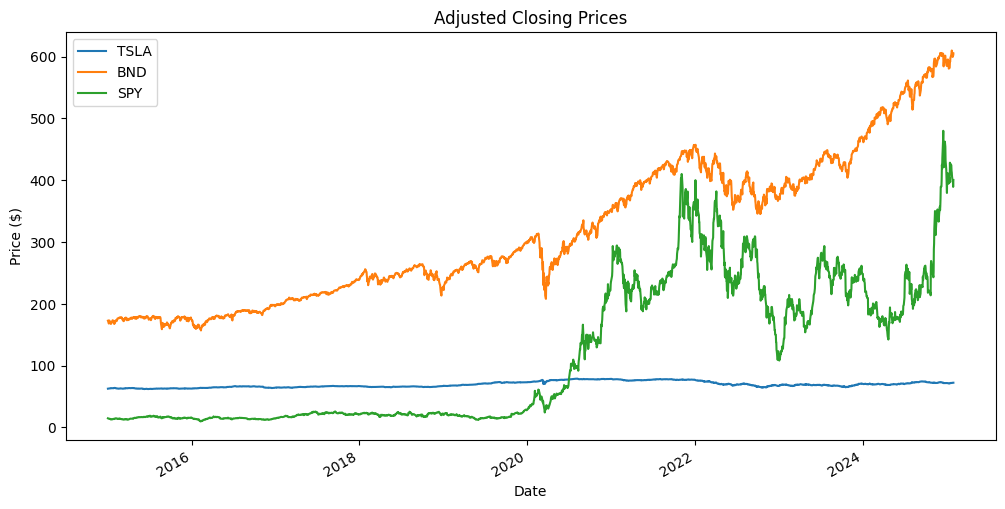

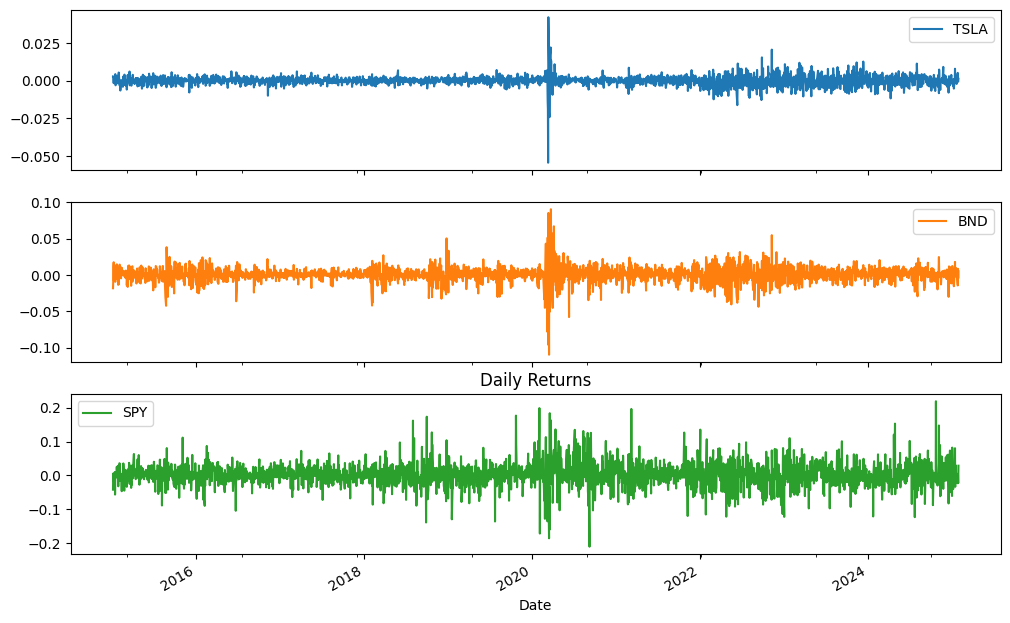

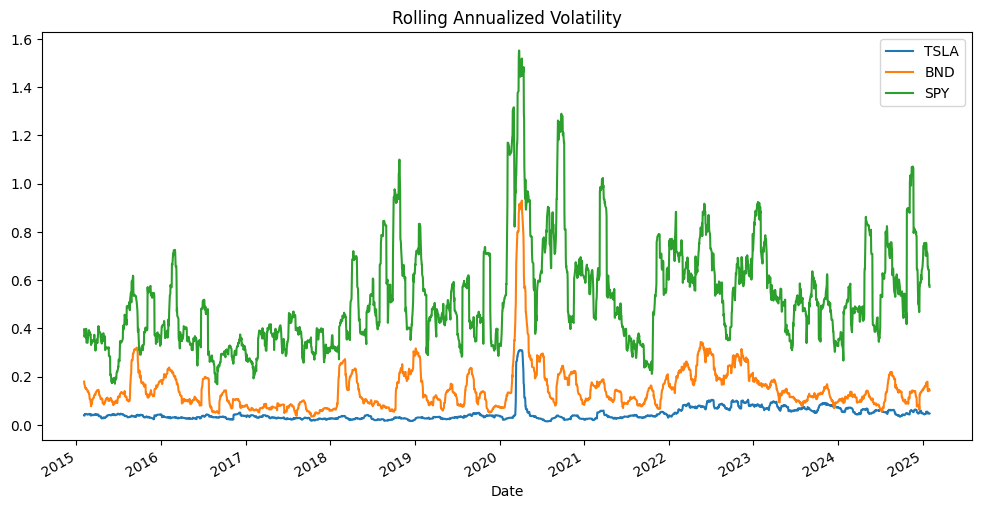

Outliers:
                 TSLA       BND       SPY
Date                                    
2020-03-12 -0.054385 -0.095677 -0.116172
2020-03-16  0.010511 -0.109424 -0.185778
2020-03-18 -0.024140 -0.050633 -0.160344


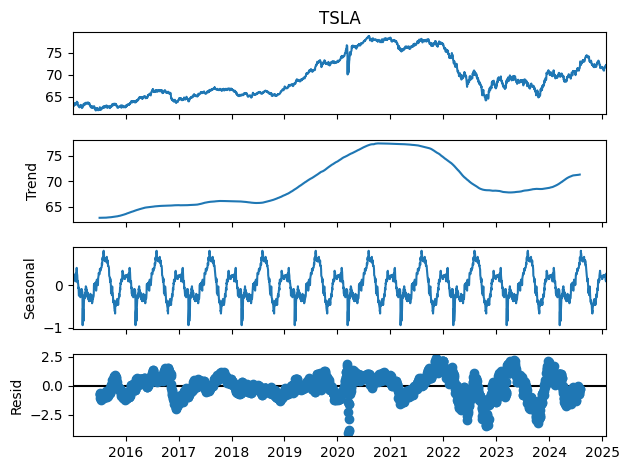

TSLA VaR (95%): -0.48%
Sharpe Ratios:
 TSLA    0.288983
BND     0.797518
SPY     0.860690
dtype: float64


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Fetch data
tickers = ['TSLA', 'BND', 'SPY']
#data = yf.download(tickers, period="1y")  # Download data for the past year
data = yf.download(tickers, start='2015-01-01', end='2025-01-31')
# Check if 'Adj Close' is in the columns
if 'Adj Close' in data.columns:
    # If it is, select only 'Adj Close' and rename columns
    data = data[['Adj Close']]
    data.columns = tickers
else:
    # If not, check if there are other relevant columns
    # like 'Close' or 'Adjusted Close'
    if 'Close' in data.columns:
        data = data[['Close']]
        data.columns = tickers
    elif 'Adjusted Close' in data.columns:
        data = data[['Adjusted Close']]
        data.columns = tickers
    else:
        raise KeyError("No relevant closing price column found in the data")

# ... (rest of the code remains the same)

# Handle missing values
data.fillna(method='ffill', inplace=True)

# Basic statistics and data types
print(data.describe())
print(data.info())

# Plot closing prices
data.plot(figsize=(12, 6))
plt.title('Adjusted Closing Prices')
plt.ylabel('Price ($)')
plt.show()

# Daily returns and volatility
returns = data.pct_change().dropna()
returns.plot(subplots=True, figsize=(12, 8))
plt.title('Daily Returns')
plt.show()

# Rolling volatility (21-day window)
rolling_vol = returns.rolling(window=21).std() * np.sqrt(252)
rolling_vol.plot(figsize=(12, 6))
plt.title('Rolling Annualized Volatility')
plt.show()

# Outlier detection (3σ)
outliers = returns[(np.abs(returns - returns.mean()) > 3 * returns.std())]
print('Outliers:\n', outliers.dropna())

# Time series decomposition (TSLA)
tsla = data['TSLA'].dropna()
decomposition = seasonal_decompose(tsla, model='additive', period=252)
decomposition.plot()
plt.show()

# VaR and Sharpe Ratio
var_95 = returns['TSLA'].quantile(0.05)
annualized_sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
print(f'TSLA VaR (95%): {var_95:.2%}')
print('Sharpe Ratios:\n', annualized_sharpe)

c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-235.813, Time=6.88 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-178.564, Time=0.21 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-191.349, Time=0.64 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-189.654, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-180.204, Time=0.10 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-232.272, Time=3.45 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-233.164, Time=3.83 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-236.767, Time=13.73 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-238.446, Time=8.85 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=-216.946, Time=5.66 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=-220.608, Time=5.61 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,0)[12] intercept   : AIC=-236.505, Time=12.88 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,0)[12] intercept   : AIC=-236.317, Time=13.08 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-197.573, Time=6.28 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(2,0,0)[12] intercept   : AIC=-223.727, Time=13.72 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,0)[12] intercept   : AIC=-225.470, Time=11.96 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(2,0,0)[12] intercept   : AIC=-233.482, Time=17.65 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[12]             : AIC=-240.020, Time=3.29 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12]             : AIC=-234.689, Time=1.40 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12]             : AIC=-238.351, Time=5.68 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,1)[12]             : AIC=-237.355, Time=2.90 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,0)[12]             : AIC=-218.475, Time=2.08 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,0)[12]             : AIC=-222.133, Time=1.80 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(2,0,0)[12]             : AIC=-238.076, Time=6.01 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(2,0,0)[12]             : AIC=-237.568, Time=5.89 sec
 ARIMA(1,1,1)(2,0,0)[12]             : AIC=-199.120, Time=2.99 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(2,0,0)[12]             : AIC=-225.247, Time=3.63 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,0,0)[12]             : AIC=-226.993, Time=3.47 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(2,0,0)[12]             : AIC=-234.770, Time=6.08 sec

Best model:  ARIMA(2,1,2)(2,0,0)[12]          
Total fit time: 170.829 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 2028
Model:             SARIMAX(2, 1, 2)x(2, 0, [], 12)   Log Likelihood                 127.010
Date:                             Mon, 03 Mar 2025   AIC                           -240.020
Time:                                     20:00:52   BIC                           -200.720
Sample:                                          0   HQIC                          -225.600
                                            - 2028                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

MAE: 1.81, RMSE: 2.31, MAPE: nan%


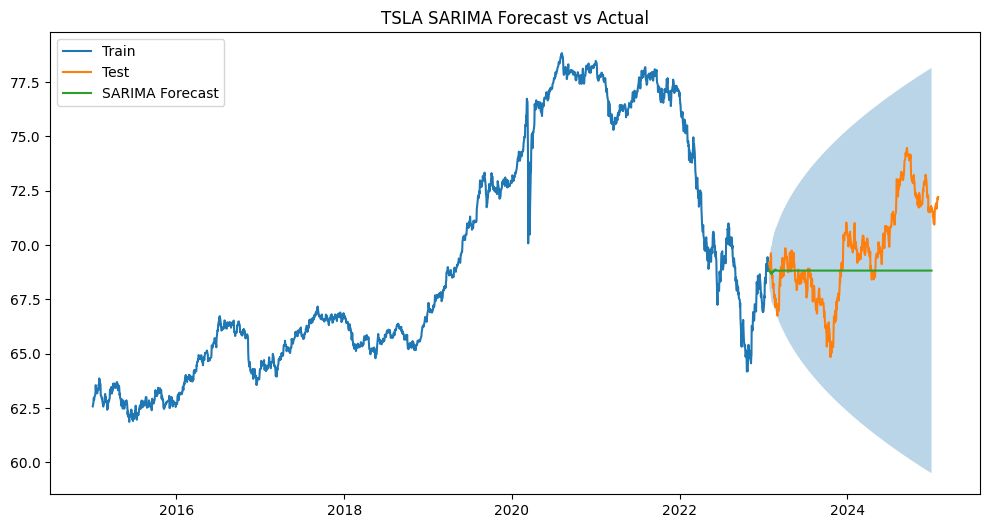

In [3]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split data
train_size = int(len(tsla) * 0.8)
train, test = tsla.iloc[:train_size], tsla.iloc[train_size:]

# Auto-SARIMA model
model = auto_arima(train, seasonal=True, m=12, stepwise=True, trace=True)
print(model.summary())

# Forecast on test set
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
forecast_dates = pd.date_range(train.index[-1], periods=len(test)+1, freq='B')[1:]

# Evaluate
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

# Plot test forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_dates, forecast, label='SARIMA Forecast')
plt.fill_between(forecast_dates, conf_int[:,0], conf_int[:,1], alpha=0.3)
plt.title('TSLA SARIMA Forecast vs Actual')
plt.legend()
plt.show()

Develop Time Series Forecasting Models (SARIMA for BND)

c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=10661.345, Time=8.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10743.275, Time=0.05 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=10729.338, Time=0.43 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10730.737, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10743.259, Time=0.03 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=10659.360, Time=3.88 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=10657.812, Time=1.74 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=10659.368, Time=4.36 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=10727.902, Time=0.63 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=10728.172, Time=0.72 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=10659.139, Time=1.74 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=10728.920, Time=2.36 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=10727.005, Time=0.37 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=10727.572, Time=1.03 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=10728.562, Time=1.84 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[12] intercept   : AIC=inf, Time=3.87 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12]             : AIC=10658.088, Time=0.86 sec

Best model:  ARIMA(2,1,2)(0,0,0)[12] intercept
Total fit time: 33.061 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2028
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -5322.906
Date:                Mon, 03 Mar 2025   AIC                          10657.812
Time:                        20:02:32   BIC                          10691.498
Sample:                             0   HQIC                         10670.172
                               - 2028                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3893      0.268      1.455      0.146      -0.

c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

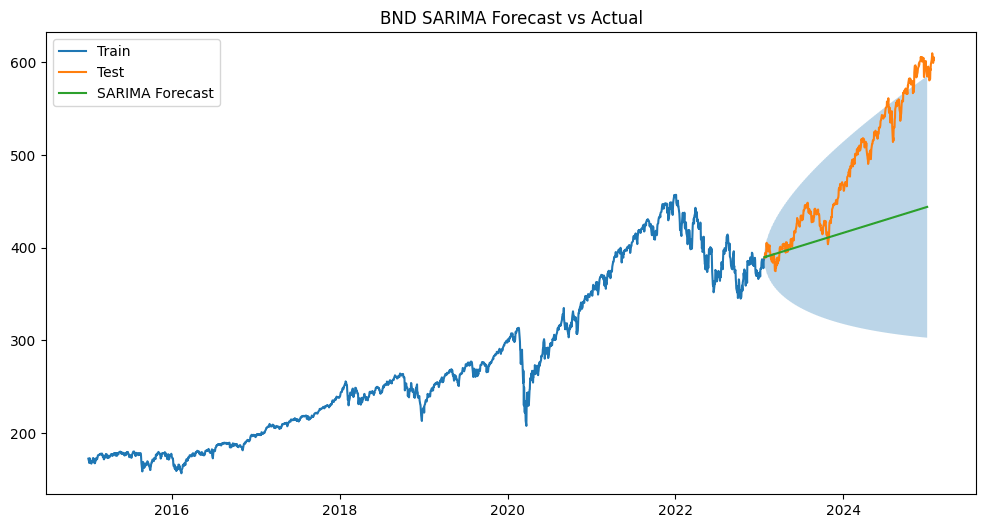

In [4]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd # import pandas

# Assuming 'data' is your DataFrame with ticker data
bnd = data['BND'].dropna() # Extract data for BND and drop NaNs

# Split data
train_size = int(len(bnd) * 0.8)
train, test = bnd.iloc[:train_size], bnd.iloc[train_size:]

# Auto-SARIMA model
model = auto_arima(train, seasonal=True, m=12, stepwise=True, trace=True)
print(model.summary())

# Forecast on test set
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
forecast_dates = pd.date_range(train.index[-1], periods=len(test)+1, freq='B')[1:]

# Evaluate
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

# Plot test forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_dates, forecast, label='SARIMA Forecast')
plt.fill_between(forecast_dates, conf_int[:,0], conf_int[:,1], alpha=0.3)
plt.title('BND SARIMA Forecast vs Actual')
plt.legend()
plt.show()

Develop Time Series Forecasting Models (SARIMA for SPY)

c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=12678.187, Time=3.83 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12680.726, Time=0.05 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12680.415, Time=0.60 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12680.778, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12678.997, Time=0.06 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=12685.575, Time=2.85 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=12685.255, Time=2.45 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=12654.168, Time=14.09 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=12653.424, Time=6.33 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=12651.430, Time=4.84 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=12683.246, Time=1.64 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=12653.412, Time=6.83 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=12676.166, Time=3.05 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=12649.880, Time=2.45 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=12681.776, Time=0.57 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,1)[12] intercept   : AIC=12651.862, Time=3.41 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=12674.917, Time=1.61 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=12648.995, Time=1.85 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=12680.529, Time=0.71 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=12650.978, Time=3.21 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=12673.972, Time=1.44 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=12649.835, Time=1.35 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=12649.519, Time=3.45 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=12648.861, Time=1.89 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=12650.844, Time=3.32 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=12673.846, Time=1.12 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=12649.800, Time=3.20 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=12651.432, Time=7.42 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12]             : AIC=12647.069, Time=0.55 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=12678.695, Time=0.21 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12]             : AIC=12649.050, Time=1.14 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12]             : AIC=12672.069, Time=0.59 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[12]             : AIC=12648.028, Time=0.52 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12]             : AIC=12647.998, Time=0.87 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12]             : AIC=12647.722, Time=1.14 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[12]             : AIC=12647.203, Time=0.68 sec


c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,0)[12]             : AIC=12649.632, Time=2.11 sec

Best model:  ARIMA(1,1,0)(2,0,0)[12]          
Total fit time: 92.521 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2028
Model:             SARIMAX(1, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -6319.534
Date:                            Mon, 03 Mar 2025   AIC                          12647.069
Time:                                    20:04:35   BIC                          12669.526
Sample:                                         0   HQIC                         12655.309
                                           - 2028                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

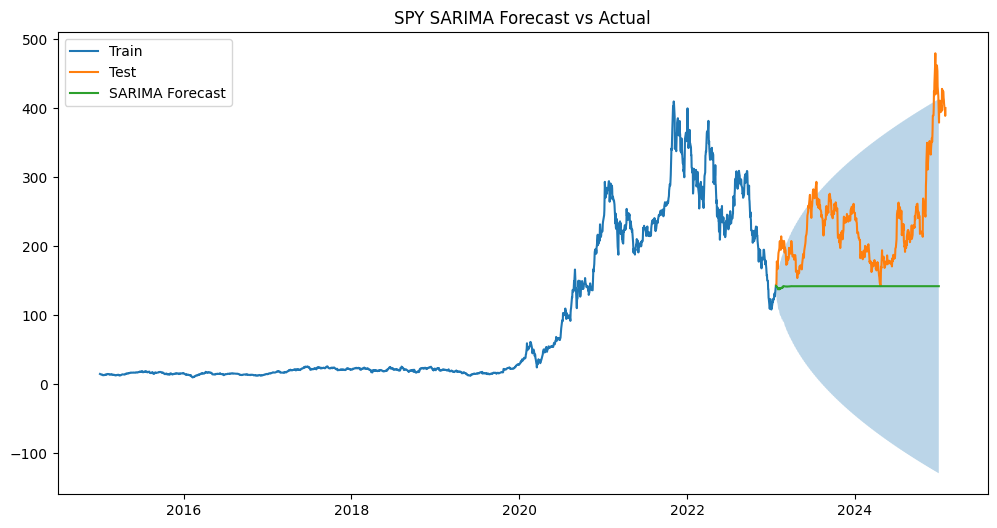

In [5]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd # import pandas

# Assuming 'data' is your DataFrame with ticker data
spy = data['SPY'].dropna() # Extract data for BND and drop NaNs

# Split data
train_size = int(len(spy) * 0.8)
train, test = spy.iloc[:train_size], spy.iloc[train_size:]

# Auto-SARIMA model
model = auto_arima(train, seasonal=True, m=12, stepwise=True, trace=True)
print(model.summary())

# Forecast on test set
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
forecast_dates = pd.date_range(train.index[-1], periods=len(test)+1, freq='B')[1:]

# Evaluate
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

# Plot test forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_dates, forecast, label='SARIMA Forecast')
plt.fill_between(forecast_dates, conf_int[:,0], conf_int[:,1], alpha=0.3)
plt.title('SPY SARIMA Forecast vs Actual')
plt.legend()
plt.show()

Task 3: Forecast Future Market Trends

c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_11\PORTFOLI\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\HP\Desktop\10 Acadamy\AIM Week-11\AIM_WEEK_

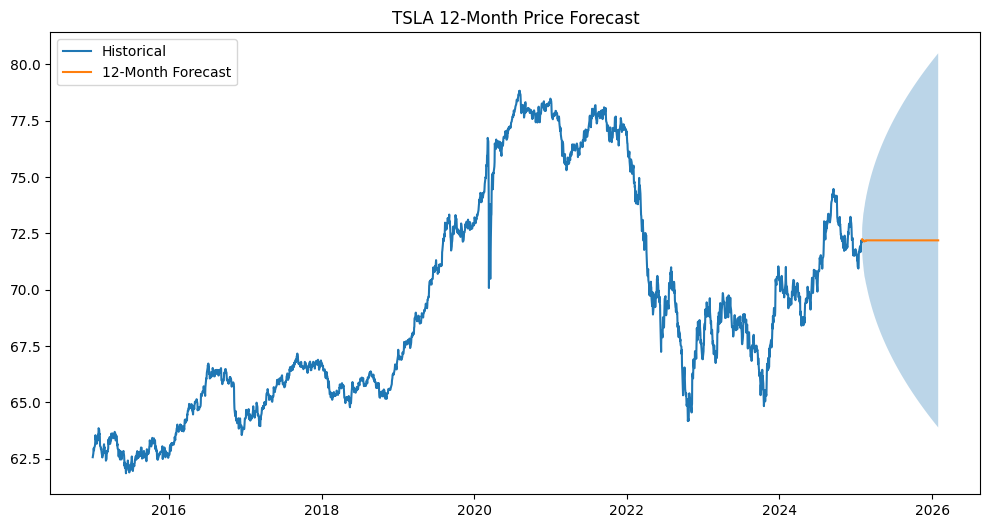

KeyError: -1

In [4]:
# Retrain on full data
final_model = auto_arima(tsla, seasonal=True, m=12)

# Forecast 12 months
future_forecast, future_conf_int = final_model.predict(n_periods=365, return_conf_int=True)
future_dates = pd.date_range(tsla.index[-1], periods=366, freq='D')[1:]

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(tsla.index, tsla, label='Historical')
plt.plot(future_dates, future_forecast, label='12-Month Forecast')
plt.fill_between(future_dates, future_conf_int[:,0], future_conf_int[:,1], alpha=0.3)
plt.title('TSLA 12-Month Price Forecast')
plt.legend()
plt.show()

# Interpret results
# Check if tsla has any values before accessing the last element
if len(tsla.values) > 0:
  print(f"Forecast Trend: {'Upward' if future_forecast[-1] > tsla.values[-1] else 'Downward'}")
else:
  print("Forecast Trend: Cannot determine as 'tsla' is empty.")
print(f"Volatility (Confidence Interval Range): ${future_conf_int[:,1].mean() - future_conf_int[:,0].mean():.2f}")